# Text Classification  -  Sentiment Analysis - Tfidf & GridSearchCV

- Apply Text Vectorization TfIdfVectorization
- Apply Classification models to text vector to predict whether the rating is positive or negative
- Apply GridSearchCV to find best Hyperparameters for Logistitics Regression, LinearSVC and  MultinomialNB

##  Required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import plotly.express as px
#import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from time import time
from sklearn import metrics

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from IPython.core.display import display, HTML

# import customised plotting functions from plot_mtrics.py script
from plot_metrics import plot_metrics_and_time, plot_radar_metrics, plot_radar_mult
from plot_metrics import plot_radar_some, barplot_metric_mult, stack_barplot
from plot_metrics import stack_mult_barplots, lineplot_models_vs_metrics, display_side_by_side

## Load data & Split into training and test data

In [2]:
# load the data
df = pd.read_csv("data_to_vect.csv" , index_col=0)

# display first lines of the data
display(df.head())

# check nan values
print(df.isna().sum())

print(df.info())

# the target variable is 0 if rating <= 3 and 1 if rating >= 4
y = (df["rating"]>3)*1  

# explanatory variable : the stemmed comment
X = df["comment_stem"]

# Set the test size at 25% of the overall sample.
# Set stratify = y to preserve labels repartition on training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25, 
                                                    stratify=y,
                                                    random_state=23)

,comment,rating,comment_cleaned,comment_lemmatized,comment_stem,stem_len
0,"Facilte, sollicitations dosées...qualité..on p...",4,facilte sollicitations dosées qualité pourrait...,facilte sollicitation doser qualité pouvoir ce...,facilt sollicit dos qualit pouvoir cepend amél...,558
1,Livraison impeccable avec possibilité de prend...,4,livraison impeccable possibilité prendre samed...,livraison impeccable possibilité prendre samed...,livraison impecc possibil prendr samed matin b...,461
2,Achat d'un canapé La Redoute intérieurs le 6/9...,4,achat canapé redoute intérieurs site redoute a...,achat canapé redoute intérieur site redoute ab...,achat canap redout intérieur sit redout abord ...,426
3,je commande depuis longtemps chez la redoute; ...,4,commande depuis longtemps redoute appréciais c...,commande depuis longtemps redoute appréciai ch...,command depuis longtemp redout appréci choix r...,370
4,"Comme d'habitude, aucun souci et rapidité d'ex...",5,habitude aucun souci rapidité expédition colis...,habitude aucun souci rapidité expédition colis...,habitud aucun souc rapid expédit colis bravo d...,366


comment               0
rating                0
comment_cleaned       0
comment_lemmatized    0
comment_stem          0
stem_len              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22683 entries, 0 to 23466
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             22683 non-null  object
 1   rating              22683 non-null  int64 
 2   comment_cleaned     22683 non-null  object
 3   comment_lemmatized  22683 non-null  object
 4   comment_stem        22683 non-null  object
 5   stem_len            22683 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB
None


## Function to fit and evaluate a model

In [3]:
# function to fit a model and calculate its metrics, time performance, classification report and confusion matrix

def fit_and_evaluate_grid(model_name, model):
    """ function to fit a model and calculate its metrics and time performance
        return a dataFrame of metrics and time performance
        encoder = 0  => fit on X_train, y_train without undersampling 
        encoder = 1 => fit on random undersampled TfIdfVectorize train data
    """
    # Fit the model to the training data
    t0 = time()
    model.fit(X_train, y_train) # model fit directly on original X_train, y_train. To be used with pipeline
    t1 = time()
    
    # Prediction on the tf-idf vectorized test data
    prediction = model.predict(X_test) 
    t2 = time()
    time_train = t1-t0
    time_predict = t2-t1

    # Evaluate model performance
    accuracy = model.score(X_test, y_test)

    # The balanced accuracy in binary and multiclass classification problems 
    # to deal with imbalanced datasets.
    # It is defined as the average of recall obtained on each class.
    # The best value is 1 and the worst value is 0 when adjusted=False.
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)   
    
    f1_score = metrics.f1_score(y_test, prediction)
    f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
    f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")
    
    recall = metrics.recall_score(y_test, prediction, pos_label=0)
    recall_macro = metrics.recall_score(y_test, prediction, average="macro")
    recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")
    
    # precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    # we set pos_label=0 : that is negative rating (rating <=3)
    precision = metrics.precision_score(y_test, prediction, pos_label=0)
    precision_macro = metrics.precision_score(y_test, prediction, average="macro" )
    precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

    cl_report = metrics.classification_report(y_test, prediction)
    cf_matrix = pd.crosstab(y_test, prediction, rownames = ["Real"], colnames=["Prediction"])

    # put metrics  into a dictionnary and into a DataFrame
    res = {"model": model_name, 
           "accuracy": accuracy, "balanced_accuracy": balanced_accuracy, 
           "f1": f1_score, "f1_macro": f1_score_macro, "f1_weighted": f1_score_weighted,
           "recall_0": recall, "recall_macro": recall_macro, "recall_weighted": recall_weighted,
           "precision_0" : precision, "precision_macro" : precision_macro, "precision_weighted" : precision_weighted,
            "time_train":time_train, "time_predict": time_predict}

    #DataFrame of model's performance
    df_p = pd.DataFrame(res, index=[0])

    #output model performance, classification report and confusion matrix
    return (df_p, cl_report, cf_matrix)
    

### Find best hyperparameters with GridSearchCV for 
- Logistitics Regression
- LinearSVC
- MultinomialNB


In [19]:

# Define piplelines : vectorization ==> Random Undersampling ==> Model
pipe_lsvc = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), svm.LinearSVC())
pipe_lreg = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), LogisticRegression())
pipe_mnnb = make_pipeline(TfidfVectorizer(), RandomUnderSampler(), MultinomialNB())

# parameter for the GridSearchCV
params_lsvc = {
            "tfidfvectorizer__min_df": [3, 4, 5],
            "tfidfvectorizer__max_df": [0.7, 0.8, 0.9, 1],
            "tfidfvectorizer__sublinear_tf": [True, False],
            "linearsvc__C": [0.01, 0.5, 1, 50]     
}

params_lreg = {
            "tfidfvectorizer__min_df": [3, 4, 5],
            "tfidfvectorizer__max_df": [0.7, 0.8, 0.9, 1],
            "tfidfvectorizer__sublinear_tf": [True, False],
            "logisticregression__C": [0.0001, 0.001, 0.01, 1, 10],
            "logisticregression__solver": ["lbfgs", "liblinear"]  
}

params_mnnb = {
            "tfidfvectorizer__min_df": [3, 4, 5],
            "tfidfvectorizer__max_df": [0.7, 0.8, 0.9, 1],
            "tfidfvectorizer__sublinear_tf": [True, False],
            "multinomialnb__alpha": [0.5, 0.8, 1]
}

grid_lsvc = GridSearchCV(estimator = pipe_lsvc, param_grid = params_lsvc, scoring = "recall_macro", cv = 5)
grid_lreg = GridSearchCV(estimator = pipe_lreg , param_grid = params_lreg, scoring = "recall_macro", cv = 5)
grid_mnnb = GridSearchCV(estimator = pipe_mnnb , param_grid = params_mnnb, scoring = "recall_macro", cv = 5)

# models to fit and evaluate
models_list = [("linear_svc", grid_lsvc), 
               ("logistic_reg", grid_lreg), 
               ("multinomialnb", grid_mnnb)]

#train and evaluate models in models_list
#train and evaluate the models after tf-idf transformation
list_of_models_pipe = []
cf_matrix_pipe = []
cl_report_pipe = []
df_pipe = pd.DataFrame([])

for (model_name, model) in models_list:  
    t0 = time()
    (df0, clrep, cfmx)  = fit_and_evaluate_grid(model_name, model)
    print("time ",time()-t0,": "+model_name + " fitted and evaluated.")
    list_of_models_pipe.append(model_name)
    df_pipe = pd.concat([df_pipe, df0])
    cl_report_pipe.append(clrep)
    cf_matrix_pipe.append(cfmx)

df_pipe = df_pipe.reset_index().drop("index", axis = 1)   



time  77.87470698356628 : linear_svc fitted and evaluated.
time  179.14509963989258 : logistic_reg fitted and evaluated.
time  48.69958281517029 : multinomialnb fitted and evaluated.


,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,linear_svc_tfidf_grid_rcm,0.884080,0.884080,0.915719,0.762919,0.879453,0.913819,0.884080,0.861400,0.457930,0.722264,0.923860,77.738714,0.044050
1,logistic_reg_tfidf_grid_rcm,0.887964,0.887964,0.907909,0.752723,0.871076,0.937593,0.887964,0.850115,0.438499,0.714287,0.924618,178.986716,0.049753
2,multinomialnb_tfidf_grid_rcm,0.884095,0.884095,0.917264,0.765285,0.881192,0.910847,0.884095,0.863692,0.462293,0.724242,0.924018,48.558748,0.044418


In [22]:
# Save metrics into a csv_file
df_temp=df_pipe.copy()
df_temp["model"] = df_temp["model"]+"_tfidf_grid_rcm"
df_temp.to_csv("perf_tfidf_grid_rcm.csv")
del df_temp

In [18]:
df_pipe

,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,linear_svc,0.886724,0.886724,0.918022,0.767319,0.882253,0.915305,0.886724,0.864927,0.464906,0.725895,0.924939,73.093196,0.045130
1,logistic_reg,0.881863,0.881863,0.906155,0.748253,0.868677,0.927192,0.881863,0.847293,0.433033,0.710724,0.922507,174.863079,0.049212
2,multinomialnb,0.880779,0.880779,0.911869,0.756081,0.874893,0.913819,0.880779,0.855581,0.446948,0.716722,0.922466,50.426996,0.045672


#### Models performance

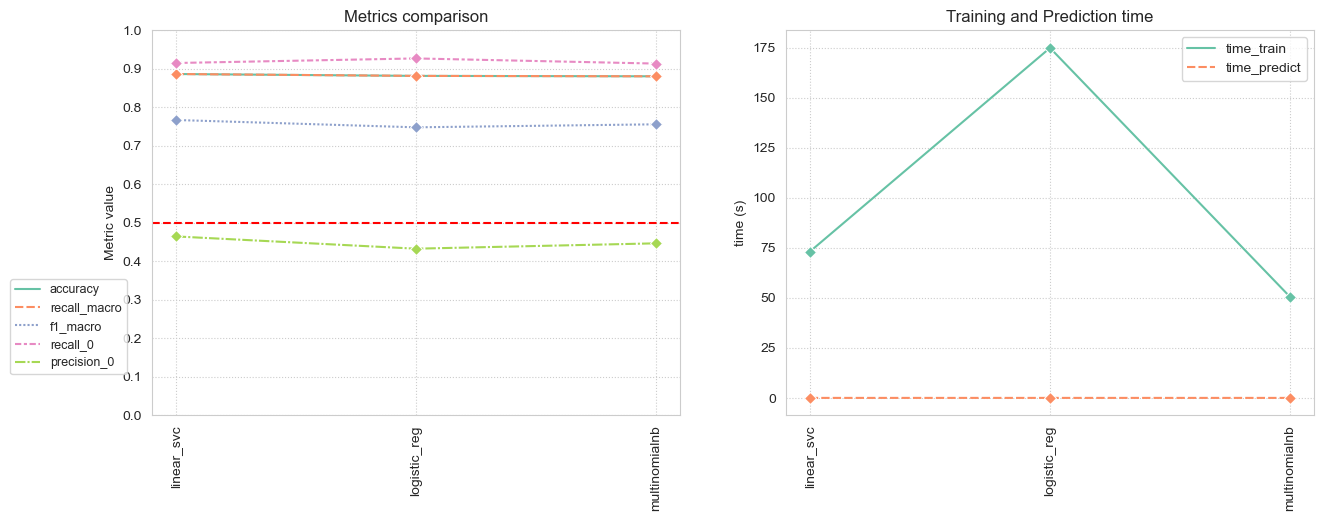

Prediction,0,1
Real,,
0,616,57
1,709,4289
Prediction,0,1
Real,,
0,624,49
1,817,4181
Prediction,0,1
Real,,
0,615,58


In [5]:
# Comparison of metrics scores
data = df_pipe.iloc[:,:-2]  # to skip time_train and time_predict
plot_radar_mult(data)

# Compare metrics and time to train and time to predict
plot_metrics_and_time(df_pipe)

# Line plots of metrics for comparison
lineplot_models_vs_metrics(data)

# Group bar plot on 5 selected metrics
stack_mult_barplots(data, "accuracy", 
                    "recall_0", "recall_macro", 
                    "precision_0", "precision_macro" )

# train performance
#barplot_metric_mult(df_pipe, "time_train")
#barplot_metric_mult(df_pipe, "time_predict")

# Comparaison of Accuracy, recall_macro, precision_macro, recall_0, precision_0
for metric in ["accuracy", 
               "recall_macro", "precision_macro", 
               "recall_0", "precision_0"]:
    barplot_metric_mult(data, metric,dtick=0.5)

# Compare time_train and time_prodict 
#stack_barplot(df_pipe, "time_train", "time_predict")

# Compare recall_macro and precision_macro
stack_barplot(df_pipe, "recall_macro", "precision_macro")

# confusion matrix
#Display(confusion matrix)
display_side_by_side(cf_matrix_pipe, list_of_models_pipe)

### Another GridSearch

In [14]:
# GridSearch with scoring unspecified
grid_lsvc = GridSearchCV(estimator = pipe_lsvc, param_grid = params_lsvc, cv = 5)
grid_lreg = GridSearchCV(estimator = pipe_lreg , param_grid = params_lreg, cv = 5)
grid_mnnb = GridSearchCV(estimator = pipe_mnnb , param_grid = params_mnnb, cv = 5)

# models to fit and evaluate
models_list = [("linear_svc_grid", grid_lsvc), 
               ("logistic_reg", grid_lreg), 
               ("multinomialnb", grid_mnnb)]

#train and evaluate models in models_list
#train and evaluate the models after tf-idf transformation
list_of_models_pipe = []
cf_matrix_pipe_2 = []
cl_report_pipe_2 = []
df_pipe_2 = pd.DataFrame([])

for (model_name, model) in models_list:  
    t0 = time()  
    (df0, clrep, cfmx)  = fit_and_evaluate_grid(model_name, model)
    print("time ",time() - t0,": "+model_name + " fitted and evaluated.")
    list_of_models_pipe.append(model_name)
    df_pipe_2 = pd.concat([df_pipe_2, df0])
    cl_report_pipe_2.append(clrep)
    cf_matrix_pipe_2.append(cfmx)

df_pipe_2 = df_pipe_2.reset_index().drop("index", axis = 1)   


time  98.46092104911804 : linear_svc_grid fitted and evaluated.
time  208.23950815200806 : logistic_reg fitted and evaluated.
time  61.86208367347717 : multinomialnb fitted and evaluated.


In [23]:
# Save metrics into a csv_file
df_temp=df_pipe_2.copy()
df_temp["model"] = df_temp["model"]+"_tfidf_grid"
df_temp.to_csv("perf_tfidf_grid.csv")
df_temp

,model,accuracy,balanced_accuracy,f1,f1_macro,f1_weighted,recall_0,recall_macro,recall_weighted,precision_0,precision_macro,precision_weighted,time_train,time_predict
0,linear_svc_grid_tfidf_grid,0.864750,0.884052,0.917977,0.766372,0.881994,0.909361,0.884052,0.864750,0.464340,0.725163,0.924081,98.273675,0.075618
1,logistic_reg_tfidf_grid,0.870217,0.876224,0.921835,0.769848,0.885761,0.884101,0.876224,0.870217,0.474860,0.728603,0.922120,208.084774,0.050392
2,multinomialnb_tfidf_grid,0.864750,0.885338,0.917942,0.766740,0.882054,0.912333,0.885338,0.864750,0.464448,0.725441,0.924488,61.707363,0.049498


#### Models performance

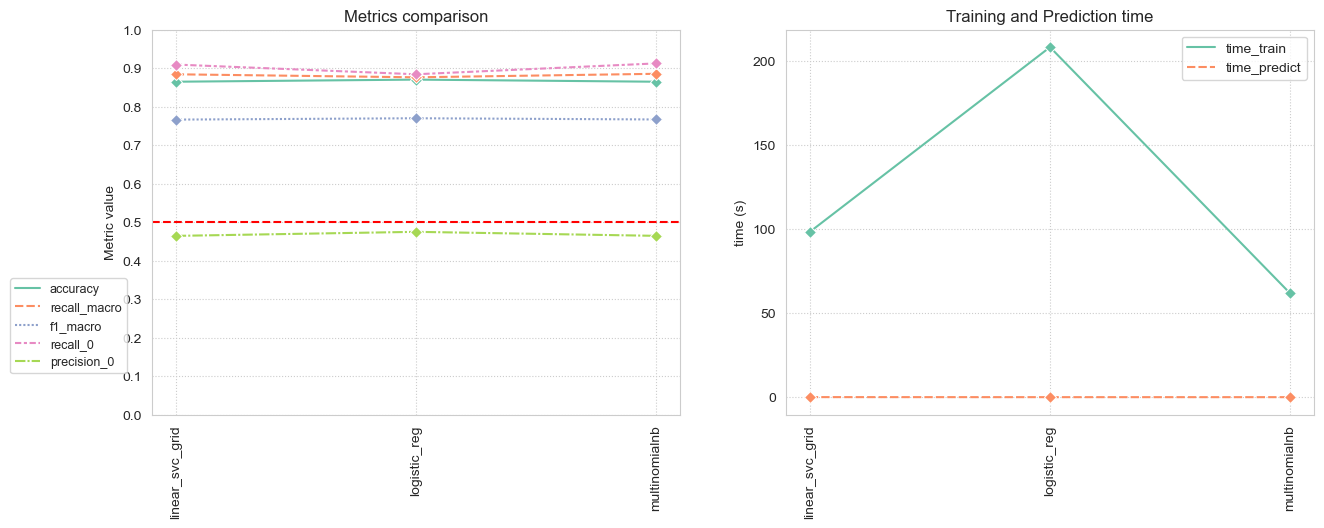

Prediction,0,1
Real,,
0,612,61
1,706,4292
Prediction,0,1
Real,,
0,595,78
1,658,4340
Prediction,0,1
Real,,
0,614,59


In [16]:
# Comparison of metrics scores
data = df_pipe_2.iloc[:,:-2]  # to skip time_train and time_predict
plot_radar_mult(data)

# Compare metrics and time to train and time to predict
plot_metrics_and_time(df_pipe_2)

# Group bar plot on 5 selected metrics
stack_mult_barplots(data, "accuracy", 
                    "recall_0", "recall_macro", 
                    "precision_0", "precision_macro" )

# Line plots of metrics for comparison
lineplot_models_vs_metrics(data)

# train performance
#barplot_metric_mult(df_pipe_2, "time_train")
#barplot_metric_mult(df_pipe_2, "time_predict")

# Comparaison of Accuracy, recall_macro, precision_macro, recall_0, precision_0
for metric in ["accuracy", "recall_macro", "precision_macro", "recall_0", "precision_0"]:
    barplot_metric_mult(data, metric)

# Compare time_train and time_prodict 
#stack_barplot(df_pipe_2, "time_train", "time_predict")

# Compare recall_macro and precision_macro
stack_barplot(df_pipe_2, "recall_macro", "precision_macro")

# Compare recall_macro and precision_macro
stack_barplot(df_pipe_2, "recall_macro", "precision_macro")

# confusion matrix
#Display(confusion matrix)
display_side_by_side(cf_matrix_pipe_2, list_of_models_pipe)

### Compare performance with GridSeachCV versus without GridSearchCV